# Introduction

This project aims to train a classification model that can predict if a user will accept a coupon given his/her answers to some survey questions. 
The attributes of the data set include:

### Data Description

The attributes of this data set include:
1. User attributes
    -  Gender: male, female
    -  Age: below 21, 21 to 25, 26 to 30, etc.
    -  Marital Status: single, married partner, unmarried partner, or widowed
    -  Number of children: 0, 1, or more than 1
    -  Education: high school, bachelors degree, associates degree, or graduate degree
    -  Occupation: architecture & engineering, business & financial, etc.
    -  Annual income: less than \\$12500, \\$12500 - \\$24999, \\$25000 - \\$37499, etc.
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she buys takeaway food: 0, less than 1, 1 to 3, 4 to 8 or greater
    than 8
    -  Number of times that he/she goes to a coffee house: 0, less than 1, 1 to 3, 4 to 8 or
    greater than 8
    -  Number of times that he/she eats at a restaurant with average expense less than \\$20 per
    person: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    -  Number of times that he/she goes to a bar: 0, less than 1, 1 to 3, 4 to 8 or greater than 8
    

2. Contextual attributes
    - Driving destination: home, work, or no urgent destination
    - Location of user, coupon and destination: we provide a map to show the geographical
    location of the user, destination, and the venue, and we mark the distance between each
    two places with time of driving. The user can see whether the venue is in the same
    direction as the destination.
    - Weather: sunny, rainy, or snowy
    - Temperature: 30F, 55F, or 80F
    - Time: 10AM, 2PM, or 6PM
    - Passenger: alone, partner, kid(s), or friend(s)

3. Coupon attributes
    - time before it expires: 2 hours or one day
    - coupon: Restaurant(<\\$20), Coffee House, Carry out & Take away, Bar, Restaurant(\\$20-\\$50)

# Data Importing

In [525]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import plotly.graph_objects as go
from collections import defaultdict
from matplotlib.ticker import FixedLocator, FixedFormatter
from joblib import dump, load
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score, RocCurveDisplay

import warnings
warnings.filterwarnings("ignore")

In [526]:
# helper function to calculate coupon acceptance rate
def get_coupon_usage_rate(data):
    return (data[data['Y'] == 1].shape[0] / data.shape[0]) * 100.0

In [527]:
df = pd.read_csv('data/coupons.csv')
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


# Data Wrangling

In [528]:
print(df.shape)
print("\nMissing values per column:")
print(df.isnull().sum())

(12684, 26)

Missing values per column:
destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64


In [529]:
# Car column has no values for 12576 out of 12684 rows. 
# Since a very large number of rows do not have Car information we can just drop the entire column. 
df.drop(columns=['car'], inplace=True)

In [530]:
# Print unique values of sparse columns
sparse_columns = ['Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50']
print("Unique values for sparse columns:")
for column in sparse_columns:
    print(f"\nColumn: {column}")
    print(df[column].unique())

# Print unique values of every column
print("unique values of all columns")
for column in df.columns:
    print(f"\nColumn: {column}")
    print(df[column].unique())

Unique values for sparse columns:

Column: Bar
['never' 'less1' '1~3' 'gt8' nan '4~8']

Column: CoffeeHouse
['never' 'less1' '4~8' '1~3' 'gt8' nan]

Column: CarryAway
[nan '4~8' '1~3' 'gt8' 'less1' 'never']

Column: RestaurantLessThan20
['4~8' '1~3' 'less1' 'gt8' nan 'never']

Column: Restaurant20To50
['1~3' 'less1' 'never' 'gt8' '4~8' nan]
unique values of all columns

Column: destination
['No Urgent Place' 'Home' 'Work']

Column: passanger
['Alone' 'Friend(s)' 'Kid(s)' 'Partner']

Column: weather
['Sunny' 'Rainy' 'Snowy']

Column: temperature
[55 80 30]

Column: time
['2PM' '10AM' '6PM' '7AM' '10PM']

Column: coupon
['Restaurant(<20)' 'Coffee House' 'Carry out & Take away' 'Bar'
 'Restaurant(20-50)']

Column: expiration
['1d' '2h']

Column: gender
['Female' 'Male']

Column: age
['21' '46' '26' '31' '41' '50plus' '36' 'below21']

Column: maritalStatus
['Unmarried partner' 'Single' 'Married partner' 'Divorced' 'Widowed']

Column: has_children
[1 0]

Column: education
['Some college - n

In [531]:
# For the column "toCoupon_GEQ5min" there is only  1 unique value for all the rows.
# Which says all the places in this are more than 5 mins away. 
# which is to say that all this column by itself is not a determining factor in accepting a coupon. 
# hence we can drop this column
df.drop(columns=['toCoupon_GEQ5min'], inplace=True)
df.isna().sum()

destination               0
passanger                 0
weather                   0
temperature               0
time                      0
coupon                    0
expiration                0
gender                    0
age                       0
maritalStatus             0
has_children              0
education                 0
occupation                0
income                    0
Bar                     107
CoffeeHouse             217
CarryAway               151
RestaurantLessThan20    130
Restaurant20To50        189
toCoupon_GEQ15min         0
toCoupon_GEQ25min         0
direction_same            0
direction_opp             0
Y                         0
dtype: int64

In [532]:
df.head()

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,never,NaN,4~8,1~3,1,0,0,1,0


In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

No much information left in the 'car' variable, we can just drop it off.

In [534]:
df.describe()

,temperature,has_children,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [535]:
df[sparse_columns] = df[sparse_columns].fillna(df[sparse_columns].mode().iloc[0])

In [536]:
df.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
direction_same          0
direction_opp           0
Y                       0
dtype: int64

In [537]:
#make a copy of cleaned dataset
clean_df = df.copy()

# Data Analysis

#plotting the value counts for all categorical features

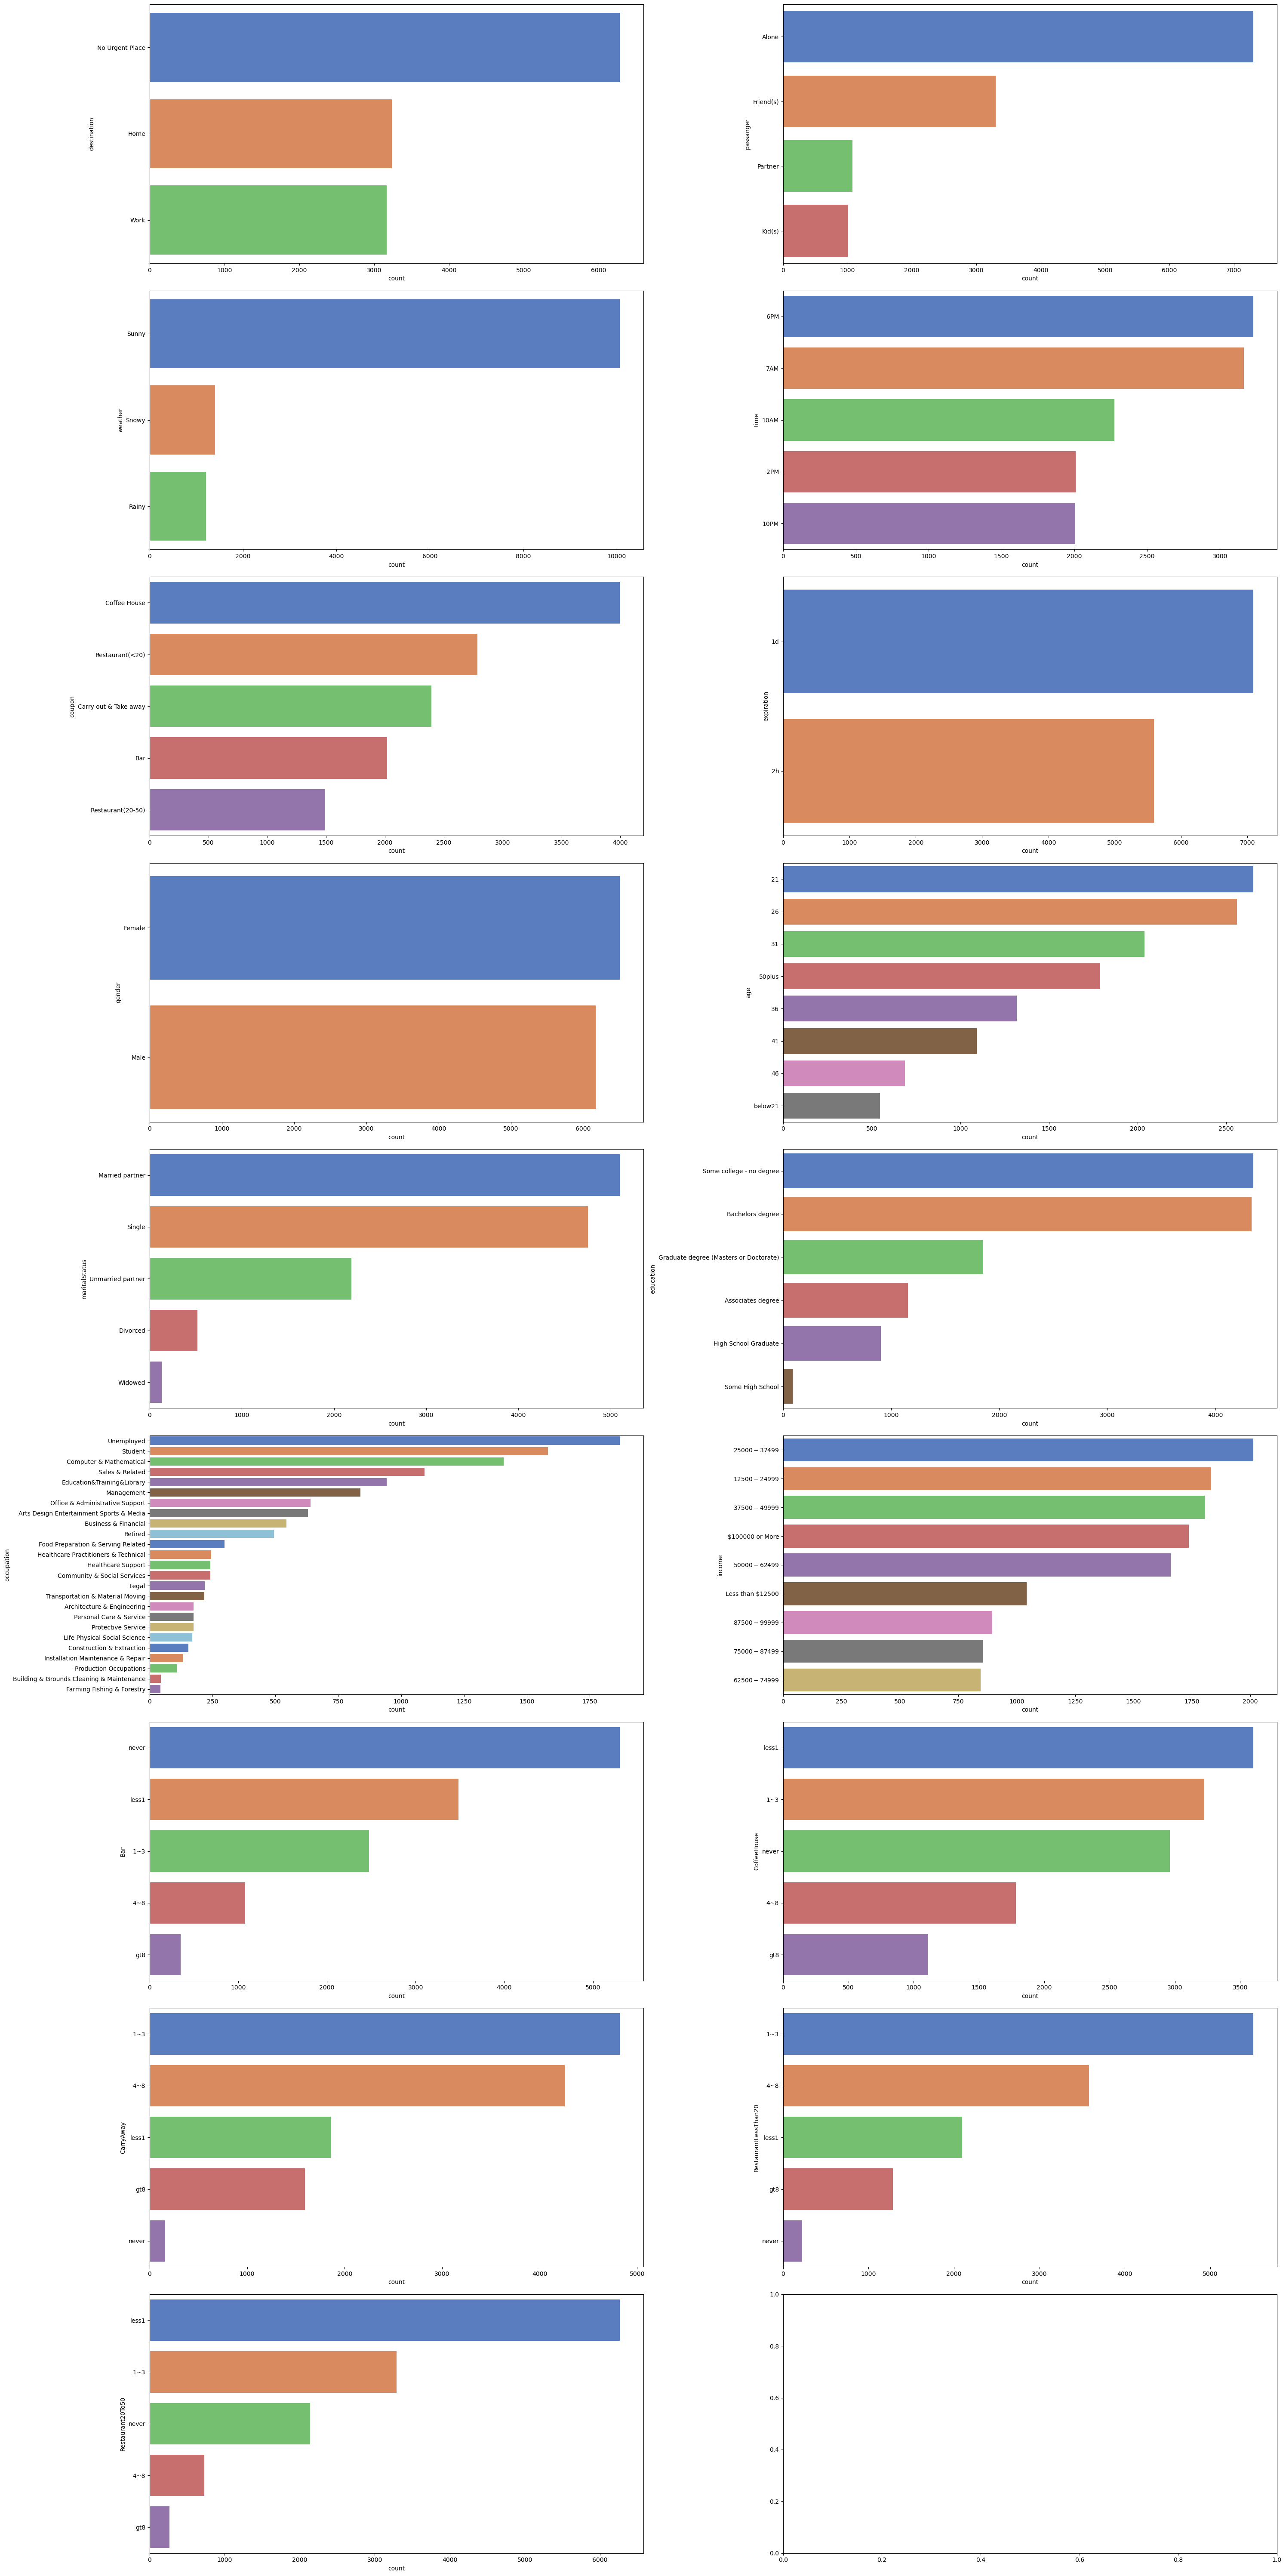

In [538]:
fig, axes = plt.subplots(9, 2, figsize=(30,60))
axes = axes.flatten()

for ax, col in zip(axes, clean_df.select_dtypes('object').columns):
    sns.countplot(y=col, 
                  data=clean_df, 
                  ax=ax, 
                  palette="muted", 
                  order=clean_df[col].value_counts().index);

plt.tight_layout()
plt.savefig('images/cat_features_value_counts.png')
plt.show() 

By analyzing the count plot of categorical features, we can identify two types of categorical data: ordinal and nominal.

Nominal Data: These categories have no intrinsic order (e.g., colors, car brands). To handle them in machine learning models, we typically apply one-hot encoding, which creates binary columns for each category.
Ordinal Data: These categories follow a meaningful order (e.g., education level, ranking). Instead of one-hot encoding, we should map them to numerical values (e.g., "low" → 1, "medium" → 2, "high" → 3) to preserve their inherent order.
This distinction ensures that models correctly interpret categorical data, preventing loss of meaningful relationships in ordinal variables. 

The ordinal features are: 

* **Restaurant20To50**: how many times do you go to a restaurant with average expense per person of \\$20 - \\$50 every month?
* **RestaurantLessThan20**: how many times do you go to a restaurant with an average expense per person of less than \\$20 every month?
* **CarryAway**: how many times do you get take-away food every month?
* **CoffeeHouse**: how many times do you go to a coffeehouse every month?
* **age**: quite self-explanatory
* **Bar**: how many times do you go to bar every month?
* **income**: income range
* **education**: education level

In [539]:
#Creating numerical mapping of values for the following features:

frequency_map = {
    'never': 0,
    'less1': 1,
    '1~3': 2,
    '4~8': 3,
    'gt8': 4
}
age_map = {
    'below21': 0,
    '21': 1,
    '26': 2,
    '31': 3,
    '36': 4,
    '41': 5,
    '46': 6,
    '50plus': 7
}
income_map = {
    'Less than $12500': 0,
    '$12500 - $24999': 1,
    '$25000 - $37499': 2,
    '$37500 - $49999': 3,
    '$50000 - $62499': 4,
    '$62500 - $74999': 5,
    '$75000 - $87499': 6,
    '$87500 - $99999': 7,
    '$100000 or More': 8
}
edu_map = {
    'Some High School': 0,
    'High School Graduate': 1,
    'Some college - no degree': 2,
    'Associates degree': 3,
    'Bachelors degree': 4,
    'Graduate degree (Masters or Doctorate)': 5
}

In [540]:
frequency_cols = ['Restaurant20To50', 'RestaurantLessThan20', 
                  'CarryAway', 'CoffeeHouse', 'Bar']

In [541]:
for col in frequency_cols:
    clean_df[col] = clean_df[col].map(frequency_map)
clean_df.age = clean_df.age.map(age_map)
clean_df.income = clean_df.income.map(income_map)
clean_df.education = clean_df.education.map(edu_map)

We can check the correlations among all the numerical features now:

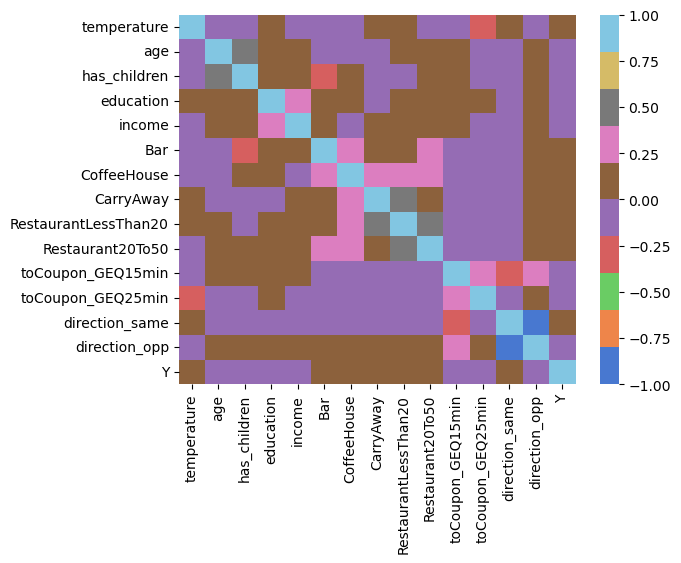

In [542]:
cmap = sns.color_palette('muted', as_cmap=True)
sns.heatmap(clean_df.select_dtypes('int64', 'float64').corr(), 
            cmap=cmap)
plt.savefig('images/numerical_features_correlations.png')
plt.show() 

As the heatmap shows, there are two columns sharing the same information: **direction_same** and **direction_opp**. They indicate whether the restaurant/bar is in the same direction as your current destination. So we decide to delete the **direction_opp** column.

Besides, there are correlations among those frequency columns: **Bar, CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50**.

In [543]:
clean_df.drop(columns=['direction_opp'], inplace=True)

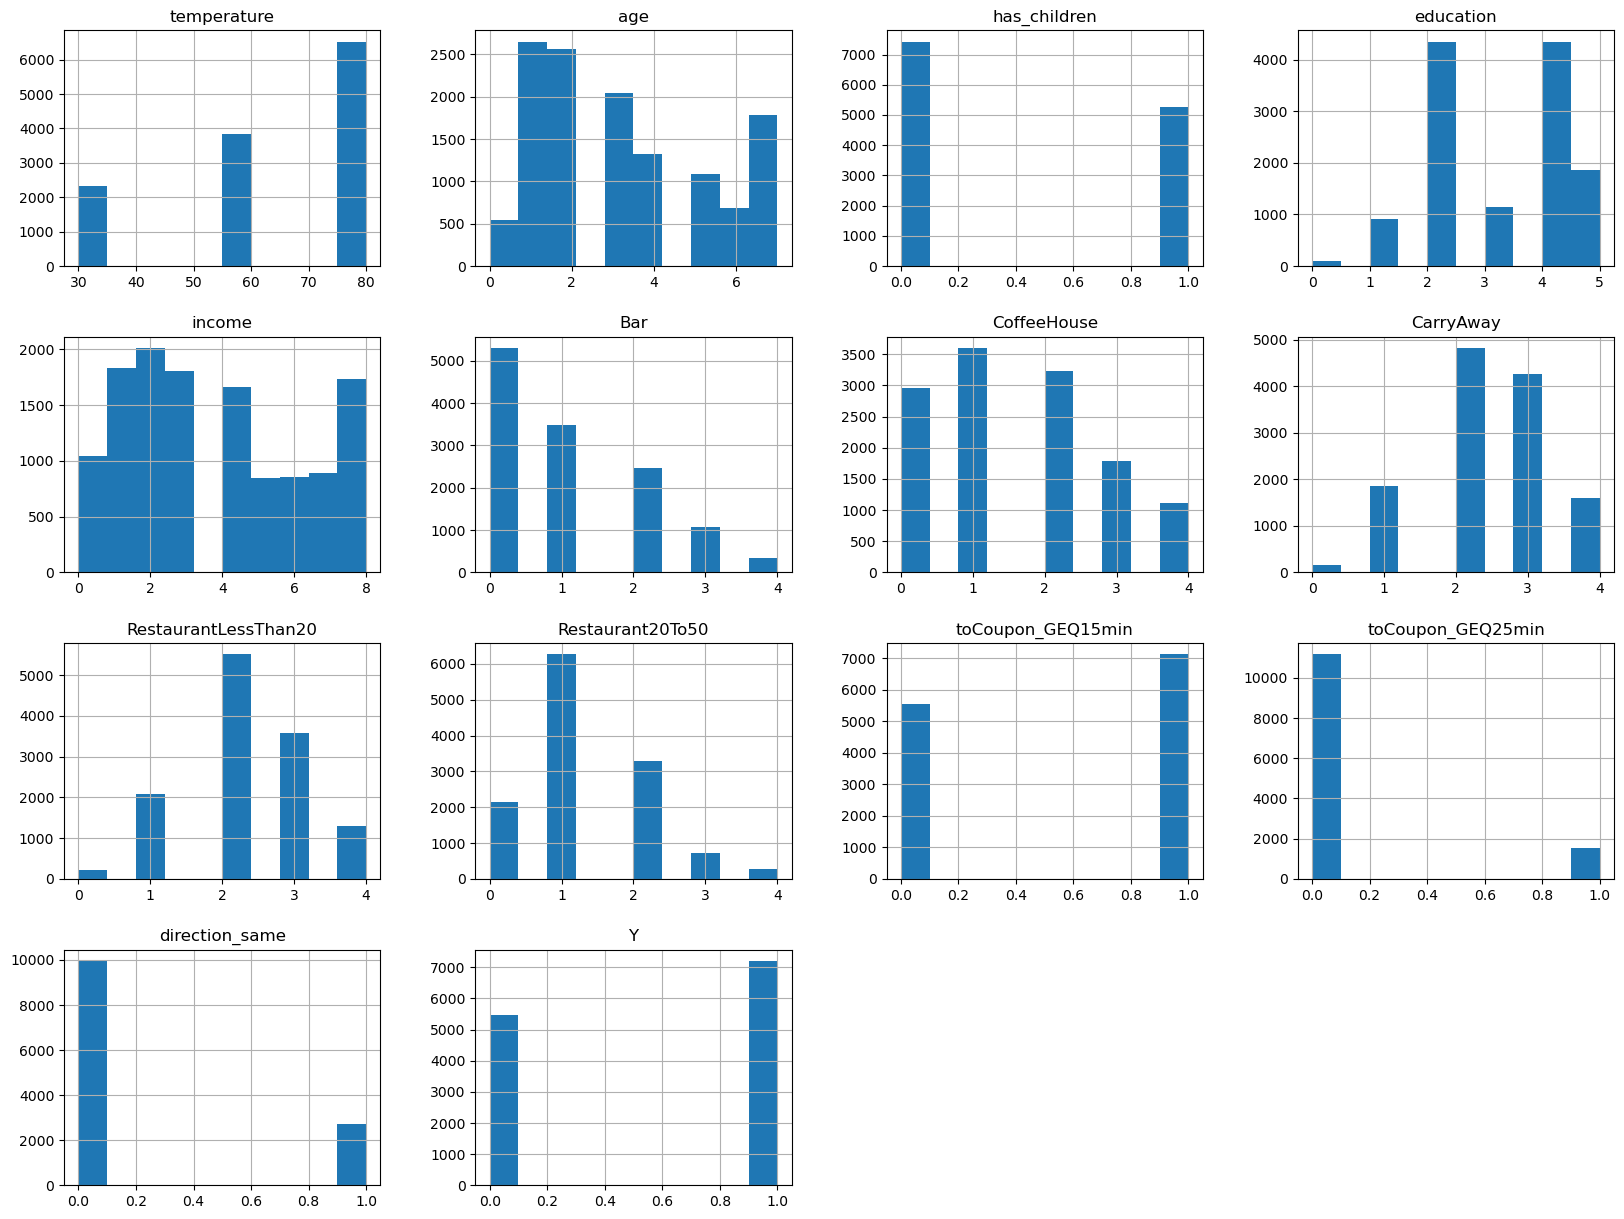

In [544]:
colors = sns.color_palette("Set2", 
                           n_colors=len(clean_df.columns))

clean_df.hist(figsize=(20, 15))
plt.savefig('images/histograms_all_features.png')
plt.show()

**toCoupon_GEQ15min, toCoupon_GEQ25min**

We have removed toCoupon_GEDQ5min, however 2 other features remain for driving distance: toCoupon_GEQ15min and toCoupon_GEQ25min. unique values for both these features are:(0/1). We can merge them into a single feature with three distinct values for: 5-15 min, 15-25 min, and 25+ min.

In [545]:
clean_df['distance'] = None

clean_df.loc[clean_df['toCoupon_GEQ15min'] == 0, 'distance'] = 0
clean_df.loc[(clean_df['toCoupon_GEQ15min'] == 1) & \
             (clean_df['toCoupon_GEQ25min'] == 0), 'distance'] = 1
clean_df.loc[clean_df['toCoupon_GEQ25min'] == 1, 'distance'] = 2

clean_df.distance.isna().sum()

0

In [546]:
clean_df.distance = clean_df.distance.astype('int64')

clean_df.distance.unique()

array([0, 1, 2])

In [547]:
clean_df.distance.value_counts()

distance
1    5611
0    5562
2    1511
Name: count, dtype: int64

In [548]:
clean_df.drop(columns=['toCoupon_GEQ15min', 'toCoupon_GEQ25min'], inplace=True)

In [549]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  int64 
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  int64 
 12  occupation            12684 non-null  object
 13  income                12684 non-null  int64 
 14  Bar                   12684 non-null  int64 
 15  CoffeeHouse           12684 non-null

Some columns needed to be transformed into categorical columns.

In [550]:
clean_df.has_children = clean_df.has_children.astype(str)
clean_df.direction_same = clean_df.direction_same.astype(str)

Print the different values for output 

In [551]:
clean_df.Y.value_counts()

Y
1    7210
0    5474
Name: count, dtype: int64

In [552]:
clean_df.shape

(12684, 22)

Now, with 22 features, we are ready to train classification models on the cleaned dataset.

In [553]:
# Save the cleaned data set
clean_df.to_csv('clean_df.csv', index=False)

# Model Training

## Data Preprocessing

From our exploratory data analysis, we found that almost all variables are categorical. Some of these can be combined to create a more meaningful new feature. To keep things simple, we will encode the remaining categorical features using OneHotEncoder, as we are primarily using sklearn for model building.

However, one drawback of OneHotEncoding is that it can negatively impact the performance of decision trees and random forests. Despite this, we must use it because RandomForestClassifier in sklearn only supports numerical data.

Considerations for Feature Engineering:
Should we apply dimensionality reduction?
After OneHotEncoding, the total number of features may exceed 50, and some frequency-related columns may be highly correlated. This makes dimensionality reduction techniques like PCA a potential option to simplify the data while preserving important information.

Should we apply feature expansion?
Creating new meaningful features from categorical data manually is challenging. However, we can look at methods like the Kernel SVM, which demonstrates the power of feature expansion. In our case, we predict that the Gaussian RBF kernel will work better than the polynomial kernel. Since most variables are categorical, measuring similarity (as the RBF kernel does) might be more useful than applying polynomial transformations.

In [554]:
X = clean_df.drop(columns=['Y'])
y = clean_df.Y

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [555]:
num_features = X_train.select_dtypes(['int64', 'float64']).columns
cat_features = X_train.select_dtypes(['object']).columns

full_pipeline = ColumnTransformer([('num', StandardScaler(), num_features),
                                   ('cat', OneHotEncoder(), cat_features)])

X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

# Extract new feature names
num_feature_names = num_features  # Numeric columns remain unchanged
cat_feature_names = full_pipeline.named_transformers_['cat'].get_feature_names_out(cat_features)

# Combine all feature names
new_feature_names = list(num_feature_names) + list(cat_feature_names)

#print numeric features
print(num_feature_names)

#print categorical features 
print(cat_feature_names)

# Print the new feature names
print(new_feature_names)

Index(['temperature', 'age', 'education', 'income', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'distance'],
      dtype='object')
['destination_Home' 'destination_No Urgent Place' 'destination_Work'
 'passanger_Alone' 'passanger_Friend(s)' 'passanger_Kid(s)'
 'passanger_Partner' 'weather_Rainy' 'weather_Snowy' 'weather_Sunny'
 'time_10AM' 'time_10PM' 'time_2PM' 'time_6PM' 'time_7AM' 'coupon_Bar'
 'coupon_Carry out & Take away' 'coupon_Coffee House'
 'coupon_Restaurant(20-50)' 'coupon_Restaurant(<20)' 'expiration_1d'
 'expiration_2h' 'gender_Female' 'gender_Male' 'maritalStatus_Divorced'
 'maritalStatus_Married partner' 'maritalStatus_Single'
 'maritalStatus_Unmarried partner' 'maritalStatus_Widowed'
 'has_children_0' 'has_children_1' 'occupation_Architecture & Engineering'
 'occupation_Arts Design Entertainment Sports & Media'
 'occupation_Building & Grounds Cleaning & Maintenance'
 'occupation_Business & Financial'
 'occupation_Community & So

In [524]:
X_train.shape, X_test.shape

((10147, 68), (2537, 68))

With OneHotEncoding, we have 68 features. 

As a first step, I intend to build models with these features (i.e, No dimension reduction)

## Basic Models

In [404]:
# generic helper function to evaluate the different models
# The function evaluate_model(model, X_test, y_test) evaluates the trained models by:
# Predicting the test set labels.
# Printing cross-validation scores and test accuracy.
# Displaying classification reports.
# Visualizing ROC curves and saving them as PNG images.

def evaluate_model(model, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    
    print("Cross Validation score of the Estimator: {0:.3f}".format(model.best_score_))
    print("Accuracy on test data: {0:.3f}".format(model.score(X_test, y_test)))
    print(metrics.classification_report(y_test, y_pred))
    print("Model Parameters: {}".format(model.best_params_))
    
    roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test)
    roc_display.line_.set_color("red")  # Change line color
    roc_display.line_.set_linestyle("--")  # Make it dashed
    #plt.title("ROC Curve for Model  {model.__class__.__name__}")
    plt.title(f"ROC Curve for model {model.estimator.__class__.__name__}")
    plt.savefig(f"images/ROC_curve_for_model_{model.estimator.__class__.__name__}.png")
    plt.show()

### Logistic Regression

Cross Validation score of the Estimator: 0.684
Accuracy on test data: 0.673
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'solver': 'lbfgs'}


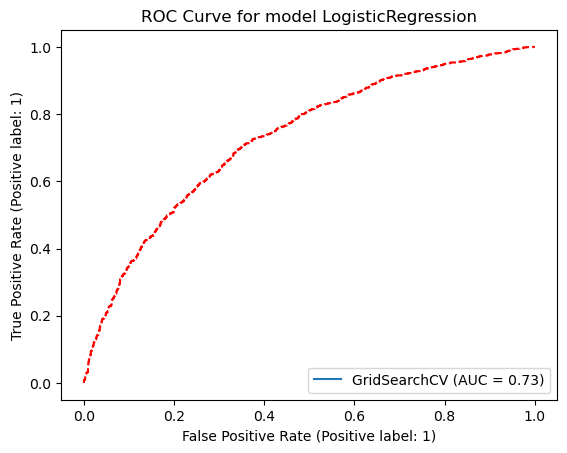

In [405]:
# Lasso Regression: Uses L1 penalty with solvers liblinear and saga.
# Ridge Regression: Uses L2 penalty with solvers newton-cg, lbfgs, sag, and saga.
# Both models tune the regularization parameter C.
# solver: Specifies optimization algorithm for logistic regression.
# setting Maximum iterations to 200 for convergence
# setting random_state to a specific value for reproducibility.
# param_grid is used to tune the hyperparameters in GridSearchCV
    
param_grid = dict(solver=['newton-cg', 'lbfgs', 'sag', 'saga'])

logreg_model = LogisticRegression(max_iter=200,
                                  random_state=0)
logreg_gscv = GridSearchCV(estimator=logreg_model, 
                           param_grid=param_grid)

logreg_gscv.fit(X_train, y_train)
evaluate_model(logreg_gscv)

#### Lasso

Cross Validation score of the Estimator: 0.685
Accuracy on test data: 0.674
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'C': 1, 'solver': 'saga'}


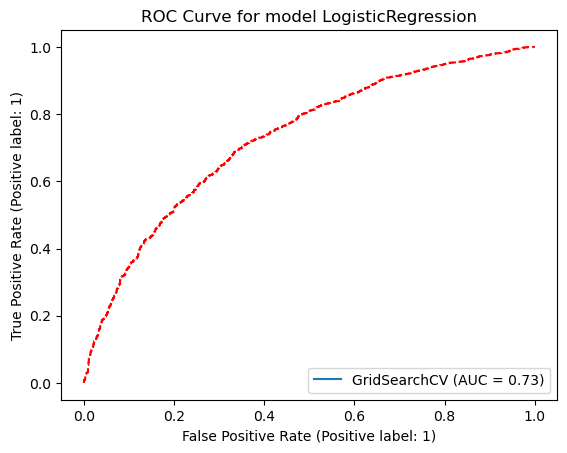

In [406]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)], 
                 solver=['liblinear', 'saga'])
lasso_model = LogisticRegression(penalty='l1', 
                                 max_iter=200,
                                 random_state=0)

lasso_gscv = GridSearchCV(estimator=lasso_model, 
                          param_grid=param_grid)
lasso_gscv.fit(X_train, y_train)
evaluate_model(lasso_gscv)

#### Ridge

Cross Validation score of the Estimator: 0.685
Accuracy on test data: 0.674
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.73      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'C': 0.1, 'solver': 'newton-cg'}


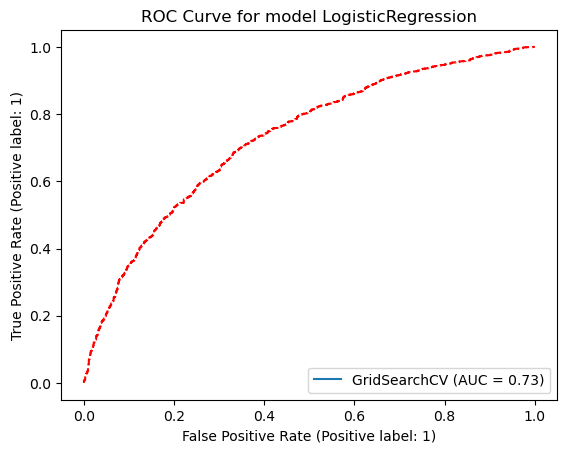

In [407]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                  solver=['newton-cg', 'lbfgs', 'sag', 'saga'])

ridge_model = LogisticRegression(penalty='l2', 
                                 max_iter=200,
                                 random_state=0)

ridge_gscv = GridSearchCV(estimator=ridge_model, 
                          param_grid=param_grid)

ridge_gscv.fit(X_train, y_train)
evaluate_model(ridge_gscv)

All the logistic regression models have the same accuracy no matter which penalty and which set of parameter are used. Let's switch to other models.

### Decision Tree

Cross Validation score of the Estimator: 0.684
Accuracy on test data: 0.686
              precision    recall  f1-score   support

           0       0.70      0.49      0.58      1111
           1       0.68      0.84      0.75      1426

    accuracy                           0.69      2537
   macro avg       0.69      0.66      0.66      2537
weighted avg       0.69      0.69      0.67      2537

Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


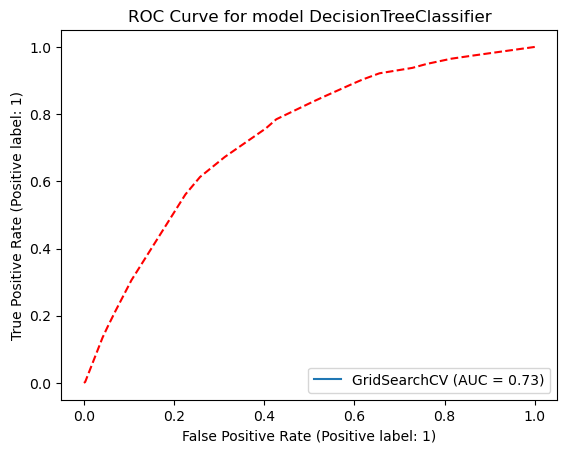

In [408]:
param_grid = dict(criterion=['gini', 'entropy'],
                  min_samples_split=[2, 10],
                  max_depth=[5, 10],
                  min_samples_leaf=[1, 10],
                  max_leaf_nodes=[10, 20])

dt_gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                       param_grid, 
                       scoring='accuracy')

dt_gscv.fit(X_train, y_train)
evaluate_model(dt_gscv)

### Naive Bayes

#### Gaussian Naive Bayes

Cross Validation score of the Estimator: 0.636
Accuracy on test data: 0.637
              precision    recall  f1-score   support

           0       0.58      0.63      0.60      1111
           1       0.69      0.64      0.67      1426

    accuracy                           0.64      2537
   macro avg       0.63      0.64      0.63      2537
weighted avg       0.64      0.64      0.64      2537

Model Parameters: {}


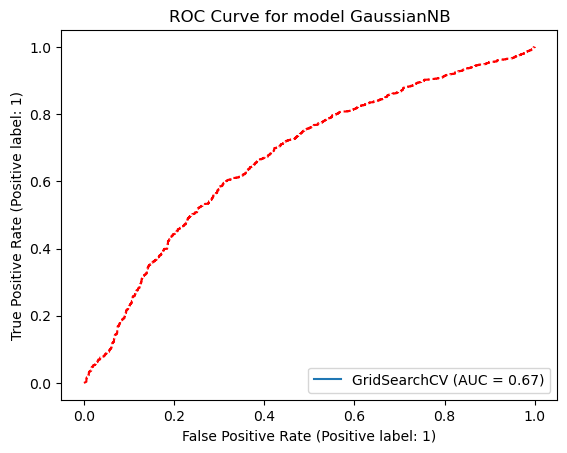

In [409]:
gnb = GaussianNB()
params = {}
gnb_gscv = GridSearchCV(gnb, 
                        params)

gnb_gscv.fit(X_train, y_train)

evaluate_model(gnb_gscv)

#### Bernoulli Naive Bayes

Cross Validation score of the Estimator: 0.657
Accuracy on test data: 0.655
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1111
           1       0.69      0.71      0.70      1426

    accuracy                           0.65      2537
   macro avg       0.65      0.65      0.65      2537
weighted avg       0.65      0.65      0.65      2537

Model Parameters: {'alpha': 1}


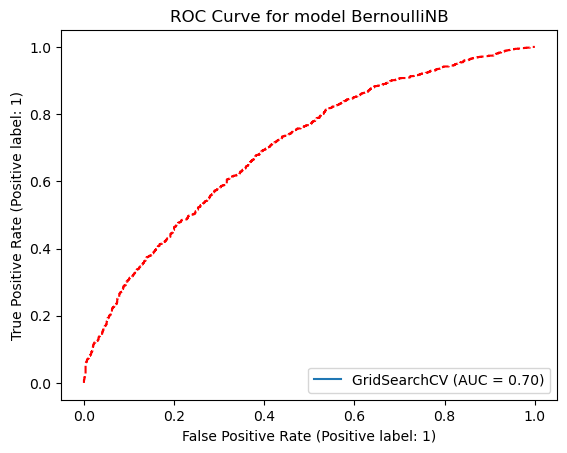

In [410]:
bnb = BernoulliNB()
param_grid = dict(alpha=[0.1, 0.3, 0.9, 1])

bnb_gscv = GridSearchCV(bnb, 
                        param_grid)
bnb_gscv.fit(X_train, y_train)

evaluate_model(bnb_gscv)

### K-nearest Neighbor

Cross Validation score of the Estimator: 0.722
Accuracy on test data: 0.732
              precision    recall  f1-score   support

           0       0.75      0.59      0.66      1111
           1       0.72      0.85      0.78      1426

    accuracy                           0.73      2537
   macro avg       0.74      0.72      0.72      2537
weighted avg       0.73      0.73      0.73      2537

Model Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


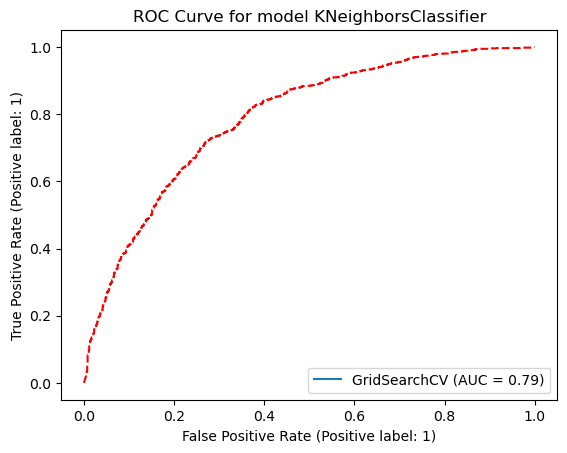

In [411]:
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 11, 19],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
}

knn_gscv = GridSearchCV(knn_clf, 
                        param_grid=param_grid)

knn_gscv.fit(X_train, y_train)
evaluate_model(knn_gscv)

### Linear SVM

Cross Validation score of the Estimator: 0.685
Accuracy on test data: 0.672
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.77      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'C': 1}


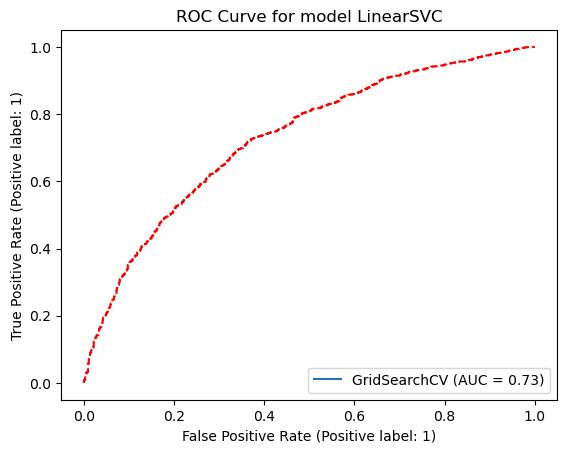

In [412]:
param_grid = dict(C=[0.1, 1, 10, 100])

linear_svc = LinearSVC(max_iter=5000, 
                       dual=False)

linear_svc_gscv = GridSearchCV(estimator=linear_svc, 
                               param_grid=param_grid)

linear_svc_gscv.fit(X_train, y_train)
evaluate_model(linear_svc_gscv)

| Model | Validation Accuracy|Testing Accuracy|AUC|
|-------|---------|-------|-----------|
|Logistic Regression with No Penalty|0.683|0.673|0.73|
|Lasso Logistic Regression|0.685|0.674|0.73|
|Ridge Logistic Regression|0.685|0.674|0.73|
|Decision Tree|0.684|0.686|0.73|
|Gaussian Naive Bayes|0.636|0.637|0.67|
|Bernoulli Naive Bayes|0.657|0.655|0.70|
|KNN Classifier|**0.722**|**0.732**|**0.79**|
|Linear SVM|0.685|0.672|0.73|

### PCA - Principal Component Analysis

Finally I explored PCA - Principal Component Analysis, to reduce the dimensions or in other words the number of features. 
Re-trained the basic models after applying PCA, to explore any improvement in performance. 

In [413]:
pca = PCA(n_components=0.95, svd_solver='full')

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.shape)

for i, component in enumerate(pca.components_):
    top_feature = new_feature_names[np.argmax(abs(component))]
    print(f"PC{i+1} is most influenced by: {top_feature}")

[0.12811801 0.09754978 0.08551411 0.06789102 0.05521497 0.05447747
 0.05097969 0.04791053 0.04489316 0.03917589 0.02995311 0.02978655
 0.02759628 0.02581459 0.0233462  0.01662535 0.01464553 0.01391491
 0.01264744 0.01093939 0.01057137 0.01017765 0.00889275 0.00807305
 0.00776118 0.00708382 0.00648027 0.00613311 0.00582614 0.00538927]
(30,)
PC1 is most influenced by: RestaurantLessThan20
PC2 is most influenced by: age
PC3 is most influenced by: temperature
PC4 is most influenced by: income
PC5 is most influenced by: distance
PC6 is most influenced by: CoffeeHouse
PC7 is most influenced by: Restaurant20To50
PC8 is most influenced by: Restaurant20To50
PC9 is most influenced by: Bar
PC10 is most influenced by: education
PC11 is most influenced by: expiration_2h
PC12 is most influenced by: RestaurantLessThan20
PC13 is most influenced by: RestaurantLessThan20
PC14 is most influenced by: destination_Home
PC15 is most influenced by: has_children_0
PC16 is most influenced by: coupon_Coffee Hous

### Logistic Regression on dataset with PCA 

ROC_curve_for_model_LogisticRegression
Cross Validation score of the Estimator: 0.679
Accuracy on test data: 0.671
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.76      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'solver': 'newton-cg'}


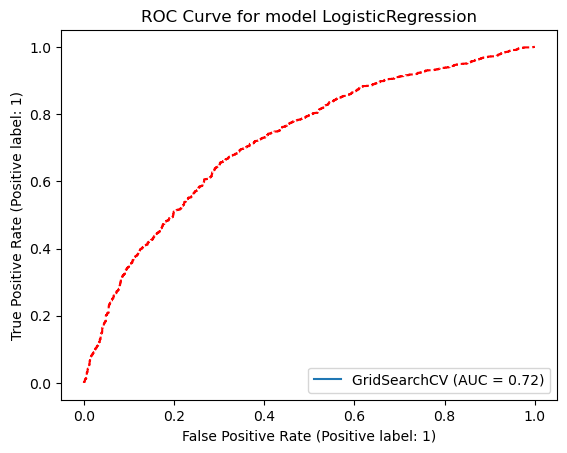

In [414]:
param_grid = dict(solver=['newton-cg', 'lbfgs', 'sag', 'saga'])

logreg_model = LogisticRegression(max_iter=200,
                                  random_state=0)

logreg_pca_gscv = GridSearchCV(estimator=logreg_model, 
                               param_grid=param_grid)

logreg_pca_gscv.fit(X_train_pca, y_train)
print(f"ROC_curve_for_model_{logreg_pca_gscv.estimator.__class__.__name__}")
evaluate_model(logreg_pca_gscv,X_test_pca, y_test)

### Lasso Regression on dataset with PCA 

Cross Validation score of the Estimator: 0.679
Accuracy on test data: 0.672
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.76      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'C': 1, 'solver': 'liblinear'}


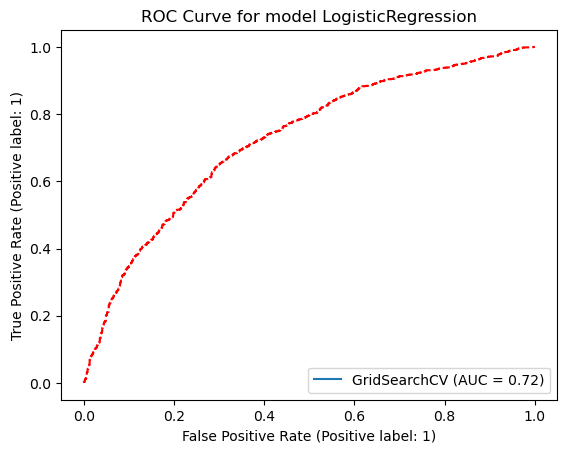

In [415]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)], 
                 solver=['liblinear', 'saga'])
lasso_model = LogisticRegression(penalty='l1', 
                                 max_iter=200,
                                 random_state=0)

lasso_pca_gscv = GridSearchCV(estimator=lasso_model, 
                              param_grid=param_grid)

lasso_pca_gscv.fit(X_train_pca, y_train)
evaluate_model(lasso_pca_gscv, X_test_pca, y_test)

### Ridge Regression on dataset with PCA 

ROC_curve_for_model_LogisticRegression
Cross Validation score of the Estimator: 0.679
Accuracy on test data: 0.671
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1111
           1       0.69      0.76      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'C': 0.1, 'solver': 'newton-cg'}


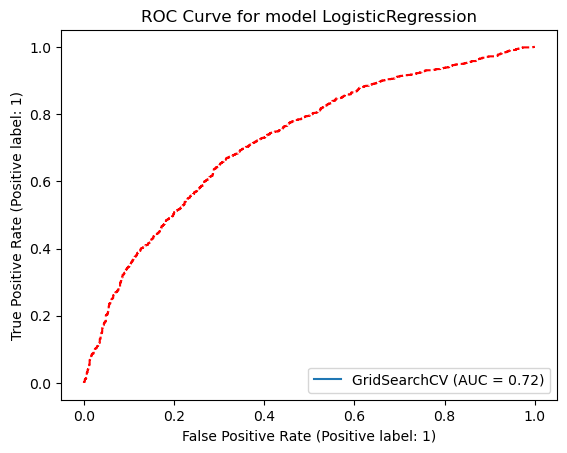

In [416]:
param_grid = dict(C=[10 ** x for x in range(-1, 2)],
                  solver=['newton-cg', 'lbfgs', 'sag', 'saga'])

ridge_model = LogisticRegression(penalty='l2', 
                                 max_iter=200,
                                 random_state=0)

ridge_pca_gscv = GridSearchCV(estimator=ridge_model, 
                              param_grid=param_grid)

ridge_pca_gscv.fit(X_train_pca, y_train)
print(f"ROC_curve_for_model_{ridge_pca_gscv.estimator.__class__.__name__}")
evaluate_model(ridge_pca_gscv, X_test_pca, y_test)

### DecisionTrees on dataset with PCA 

Cross Validation score of the Estimator: 0.650
Accuracy on test data: 0.648
              precision    recall  f1-score   support

           0       0.61      0.56      0.58      1111
           1       0.68      0.72      0.70      1426

    accuracy                           0.65      2537
   macro avg       0.64      0.64      0.64      2537
weighted avg       0.65      0.65      0.65      2537

Model Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_leaf_nodes': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}


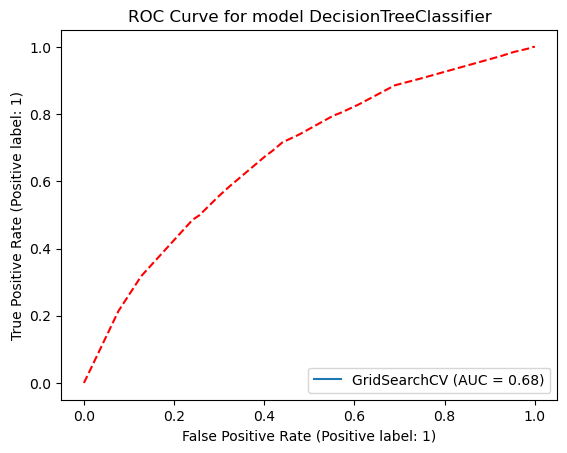

In [417]:
param_grid = dict(criterion=['gini', 'entropy'],
                  min_samples_split=[2, 10],
                  max_depth=[5, 10],
                  min_samples_leaf=[1, 10],
                  max_leaf_nodes=[10, 20])

dt_pca_gscv = GridSearchCV(DecisionTreeClassifier(random_state=0), 
                           param_grid, 
                           scoring='accuracy')

dt_pca_gscv.fit(X_train_pca, y_train)
evaluate_model(dt_pca_gscv, X_test_pca, y_test)

### Bernoulli Naive Bayes on dataset with PCA 

Cross Validation score of the Estimator: 0.651
Accuracy on test data: 0.637
              precision    recall  f1-score   support

           0       0.61      0.48      0.54      1111
           1       0.65      0.76      0.70      1426

    accuracy                           0.64      2537
   macro avg       0.63      0.62      0.62      2537
weighted avg       0.63      0.64      0.63      2537

Model Parameters: {'alpha': 0.1}


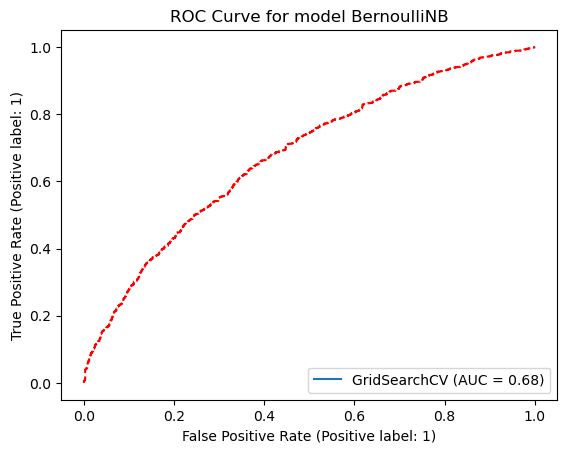

In [418]:
bnb = BernoulliNB()

param_grid = dict(alpha=[0.1, 0.3, 0.9, 1])

bnb_pca_gscv = GridSearchCV(bnb, 
                            param_grid)

bnb_pca_gscv.fit(X_train_pca, y_train)

evaluate_model(bnb_pca_gscv, X_test_pca, y_test)

### KNN - K-Nearest-Neighbors on dataset with PCA 

Cross Validation score of the Estimator: 0.722
Accuracy on test data: 0.720
              precision    recall  f1-score   support

           0       0.73      0.57      0.64      1111
           1       0.71      0.84      0.77      1426

    accuracy                           0.72      2537
   macro avg       0.72      0.70      0.71      2537
weighted avg       0.72      0.72      0.71      2537

Model Parameters: {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}


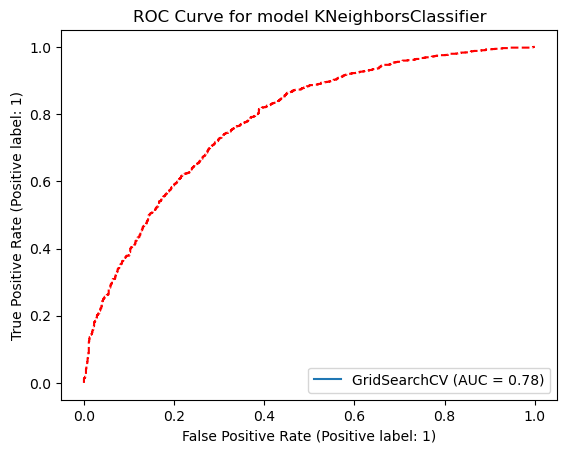

In [419]:
knn_clf = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 5, 11, 19],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']
}

knn_pca_gscv = GridSearchCV(knn_clf, 
                            param_grid=param_grid)

knn_pca_gscv.fit(X_train_pca, y_train)

evaluate_model(knn_pca_gscv, X_test_pca, y_test)

### Linear SVM on dataset with PCA 

Cross Validation score of the Estimator: 0.679
Accuracy on test data: 0.672
              precision    recall  f1-score   support

           0       0.65      0.56      0.60      1111
           1       0.69      0.76      0.72      1426

    accuracy                           0.67      2537
   macro avg       0.67      0.66      0.66      2537
weighted avg       0.67      0.67      0.67      2537

Model Parameters: {'C': 0.1}


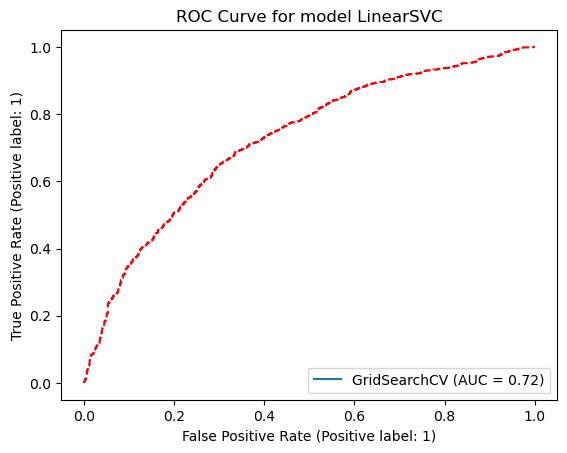

In [420]:
param_grid = dict(C=[0.1, 1, 10, 100])

linear_svc = LinearSVC(max_iter=5000, 
                       dual=False)

linear_svc_pca_gscv = GridSearchCV(estimator=linear_svc, 
                                   param_grid=param_grid)

linear_svc_pca_gscv.fit(X_train_pca, y_train)

evaluate_model(linear_svc_pca_gscv, X_test_pca, y_test)

| Models with out PCA | Validation Accuracy|Testing Accuracy|AUC|
|-------|---------|-------|-----------|
|Logistic Regression with No Penalty|0.683|0.673|0.73|
|Lasso Logistic Regression|0.685|0.674|0.73|
|Ridge Logistic Regression|0.685|0.674|0.73|
|Decision Tree|0.684|0.686|0.73|
|Bernoulli Naive Bayes|0.657|0.655|0.70|
|**KNN Classifier**|**0.722**|**0.732**|**0.79**|
|Linear SVM|0.685|0.672|0.73|

| Models with PCA | Validation Accuracy|Testing Accuracy|AUC|
|-------|---------|-------|-----------|
|Logistic Regression with No Penalty|0.679|0.671|0.72|
|Lasso Logistic Regression|0.679|0.672|0.72|
|Ridge Logistic Regression|0.679|0.671|0.72|
|Decision Tree|0.650|0.648|0.68|
|Bernoulli Naive Bayes|0.657|0.655|0.68|
|**KNN Classifier**|**0.722**|**0.720**|**0.78**|
|Linear SVM|0.679|0.672|0.72|

